In [46]:
import spacy
import math
import numpy as np
import pandas as pd
import seaborn as sb
import re
import os

%run PY_preprocessing.ipynb
%run PY_extrator.ipynb
%run PY_machine_learning.ipynb
%run PY_utilities.ipynb
%run PY_aux_extrator.ipynb

### VARIAVEIS GLOBAIS
root_input = "db-input"
root_output = "db-output"
root_tree = "images/"
output_file = "csv-saida-extrator.csv"

ls_listas = {'Lista01','Lista02','Lista03','Lista04','Lista05','Lista06'}
ls_turmas = {'T1'}

#ls_listas = {'Lista01'}
#ls_turmas = {'T2'}
ls_types = {'void', 'int', 'long', 'float', 'double', 'char'}
num_clusters = 4

<Figure size 720x216 with 0 Axes>

In [47]:
def main(printador):
    if os.path.exists(output_file):
        os.remove(output_file)
    ##-------------------------------------------------------------------------------
    ## OUTPUT: ls_turma: {T1, T2, T3}
    for ls_turma in sorted(ls_turmas):
        #get_students(ls_turma, ls_listas, root_input, root_output)
        ls_labels = []        
        
        ##-------------------------------------------------------------------------------
        ## OUTPUT: ls_turma: {Lista01, Lista02, Lista03, Lista04, Lista05, Lista06}
        for ls_lista in sorted(ls_listas):
            ## (ls_dataset): armazena um dicionário com as features e seus valores 
            ls_dataset = []
            
            ## configuração dos arquivos
            output_folder = "{}_{}_{}".format(root_output, ls_turma, ls_lista)
            output_tree = "{}/arv-{}-{}.png".format(root_tree, ls_turma, ls_lista)
            output_cluster = "{}/clt-{}-{}.png".format(root_tree, ls_turma, ls_lista)
            folder_entrada = "{}/{}/{}".format(root_input, ls_turma, ls_lista)

            ## cria o diretório de saida, caso não exista
            if os.path.exists(output_folder):
                print("\n> Folder: {} (ok).".format(output_folder))
            else:
                print("\n> The folder ({}) has been created.".format(output_folder))
                os.mkdir(output_folder)
                
            ls_todos_codigos, ls_name_files = join_tasks(folder_entrada, output_folder, False)

            ##-------------------------------------------------------------------------------
            ## OUTPUT: ls_todos_codigos: [[[cod1-joao], [cod2-joao]], [[cod1-maria], [cod2-maria]]]
            for id_aluno, (codigos_aluno, name_codes) in enumerate(zip(ls_todos_codigos, ls_name_files)):
                
                #if ls_lista == "Lista01" or ls_lista == "Lista02" or ls_lista == "Lista04" or ls_lista == "Lista05" or ls_lista == "Lista06":                
                if ls_lista == "Lista01" or ls_lista == "Lista02":                
                    features01 = set_list01()             
                    features01['CC'] = float(get_CC(id_aluno, folder_entrada))                    
                    
                #if ls_lista == "Lista02" or ls_lista == "Lista02" or ls_lista == "Lista04" or ls_lista == "Lista05" or ls_lista == "Lista06":
                if ls_lista == "Lista02" or ls_lista == "Lista06":
                    features02 = set_list02()
                
                if ls_lista == "Lista03":
                    features03 = set_list03()

                if ls_lista == "Lista04" or ls_lista == "Lista06":
                    features04 = set_list04()            

                if ls_lista == "Lista05":                
                    features05 = set_list05() 
                    
                if ls_lista == "Lista06":                
                    features06 = set_list06() 
                
                ##-------------------------------------------------------------------------------                
                if (printador):
                    get_printador_cab(id_aluno)
                    
                ##-------------------------------------------------------------------------------
                ## EXTRATOR
                for id_cod, (codigo, name_code) in enumerate(zip(codigos_aluno, name_codes)):
                    ## reescreve os comentários na lista de códigos
                    codigo, block_comm = get_block_comm(codigo)
                    codigo, line_comm = get_line_comm(codigo)
                    #?ls_variaveis, noa = nex.get_var_lc(codigo)

                    ##-------------------------------------------------------------------------------                     
                    ls_signatures, ls_flags = get_signatures(codigo, ls_types)
                    ls_functions = get_functions(codigo, ls_flags)
                    ls_calls = get_calls(codigo, ls_signatures)
                    ls_func_call = get_func_call(codigo, ls_signatures, ls_flags)
                    ##-------------------------------------------------------------------------------    

                    #if ls_lista == "Lista01" or ls_lista == "Lista02" or ls_lista == "Lista04" or ls_lista == "Lista05" or ls_lista == "Lista06":
                    if ls_lista == "Lista01" or ls_lista == "Lista02":                    
                        features01 = get_list01(features01, codigo, ls_signatures, ls_functions, ls_calls)
                        
                        ls_libs = get_calls_libs(codigo, name_codes)
                        if not ls_libs == "":
                            for (c, n) in zip(codigos_aluno, name_codes):
                                if ls_libs in n:
                                    ls_signatures, ls_flags = get_signatures(c, ls_types)
                                    features01['NOC'] += len(get_calls(codigo, ls_signatures))
                                    #print("mudou noc: {}".format(len(get_calls(codigo, ls_signatures))))
                                    break
                    
                    #if ls_lista == "Lista02" or ls_lista == "Lista02" or ls_lista == "Lista04" or ls_lista == "Lista05" or ls_lista == "Lista06":
                    if ls_lista == "Lista02" or ls_lista == "Lista06":
                        features02 = get_list02(features02, codigo, ls_signatures, ls_functions, ls_calls, ls_func_call)                        

                    if ls_lista == "Lista03":
                        features03 = get_list03(features03, codigo)
                    
                    if ls_lista == "Lista04" or ls_lista == "Lista06":
                        features04 = get_list04(features04, codigo)                    

                    if ls_lista == "Lista05":
                        features05 = get_list05(features05, codigo, ls_signatures, ls_functions) 
                        
                    if ls_lista == "Lista06":
                        features06 = get_list06(features06, codigo) 
                
                ##-------------------------------------------------------------------------------
                dict_list = {}
                
                #if ls_lista == "Lista01" or ls_lista == "Lista02" or ls_lista == "Lista04" or ls_lista == "Lista05" or ls_lista == "Lista06":
                if ls_lista == "Lista01" or ls_lista == "Lista02":
                    features01['FLOC'] = get_FLOC(features01)
                    dict_list.update(features01)
                
                
                #if ls_lista == "Lista02" or ls_lista == "Lista02" or ls_lista == "Lista04" or ls_lista == "Lista05" or ls_lista == "Lista06":
                if ls_lista == "Lista02" or ls_lista == "Lista06":
                    dict_list.update(features02)
                    if ls_lista == "Lista02":
                        dict_list['NOP'] -= (dict_list['NOPt_s'] + dict_list['NOPt_ds'])
                        
                if ls_lista == "Lista03": 
                    dict_list.update(features03)    
                                
                if ls_lista == "Lista04" or ls_lista == "Lista06":
                    dict_list.update(features04)

                if ls_lista == "Lista05":
                    dict_list.update(features05)
                    
                if ls_lista == "Lista06":
                    dict_list.update(features06)                    

                ##-------------------------------------------------------------------------------                
                if (printador):
                    get_printador(dict_list)                    
     
                ls_dataset.append(dict_list)
                   
            ##-------------------------------------------------------------------------------        
            ## EXTRATOR        
            df = pd.DataFrame(ls_dataset)
            features_cols = df.keys()
            
            ##-------------------------------------------------------------------------------        
            ## NORMALIZADOR
            #print(">>>>>>>> ANTES DO NORMALIZADOR!!!!!!!")
            #df = pd.DataFrame(normalizador(df[features_cols].values), columns=df[features_cols].keys())
            #print(df)
            
            if ls_turma == "T1":
                start_stud = 101
            elif ls_turma == "T2":
                start_stud = 201
            elif ls_turma == "T3":
                start_stud = 301
            
            ## AGRUPADOR
            df, labels = agrupador(df, features_cols, start_stud, output_cluster, num_clusters)
            ls_labels.append(labels)

            if ls_lista == "Lista01":
                column_names = ['NOF','FLOC','NOP','NOPr','NOC','NOR','CC','Label']
            elif ls_lista == "Lista02":
                column_names = ['NOF','FLOC','NOP','NOPr','NOC','NOR','CC','NOPt_s','NOPt_ds','NOAdd_s','NOAdd_ds','Label']
            elif ls_lista == "Lista03":
                column_names = ['strcpy','strcat','strcmp','stricmp','strlen','strupr','strlwr','strrev','fflush','string.h','fgets','%c','%s','x0','char','Label']
            elif ls_lista == "Lista04":
                column_names = ['NOStr','NOStrM','NOStrT','NOStrI_s','NOStrI_ds','NOStrC_s','NOStrC_ds','Label'] 
            elif ls_lista == "Lista05":
                column_names = ['NOFRec','NOCRec','NOR_diff','NOIfPar','NOPrintPar','Label']
            elif ls_lista == "Lista06":
                column_names = ['NOPt_s','NOPt_ds','NOAdd_s','NOAdd_ds','NOStr','NOStrM','NOStrT','NOStrI_s','NOStrI_ds','NOStrC_s','NOStrC_ds','NOSizeof','NOMalloc','NOFree','Label']                
            
            print("\n>>> EXTRACTED FEATURES: \n{}".format(column_names))

            df.index = df.index + start_stud
            df = df.reindex(columns=column_names)
            df.index.name = 'stud.'
            df.to_csv(output_file, mode = 'a', sep = ",")
            
            ## CLASSIFICADOR
            classificador(df, features_cols, output_tree, False)
        
    return (ls_dataset)




> Folder: db-output_T1_Lista01 (ok).
>> Total of source codes: 227
------------------------------------------------------------

>>> K-MEANS 
Silhouette: 0.4 
[1 3 0 0 0 1 2 0 3 3 0 0 1 3 2 0 1 0 3 1 0 0 2 2 2 0 1 0 0 0 0 2 2 3 0 2 0
 3 0 0 2]

>>> AGGLOMERATIVE HIERARCHICAL
Cophenetic Correlation Coefficient: 0.71 
[0 0 2 2 2 0 1 2 0 0 2 2 0 0 1 2 0 2 0 0 2 2 1 2 1 2 0 2 2 2 2 1 1 0 2 3 2
 0 2 2 1]

>>> EXTRACTED FEATURES: 
['NOF', 'FLOC', 'NOP', 'NOPr', 'NOC', 'NOR', 'CC', 'Label']

> Folder: db-output_T1_Lista02 (ok).
>> Total of source codes: 113
------------------------------------------------------------

>>> K-MEANS 
Silhouette: 0.56 
[0 0 1 1 1 0 2 1 0 2 1 1 2 0 1 0 2 1 0 2 2 1 0 2 2 1 0 1 0 1 2 0 0 0 1 3 1
 0 1 2 0]

>>> AGGLOMERATIVE HIERARCHICAL
Cophenetic Correlation Coefficient: 0.87 
[2 2 1 1 1 2 0 1 2 0 1 1 0 2 1 2 0 1 2 0 0 1 2 0 0 1 2 1 2 1 0 2 2 2 1 3 1
 2 1 0 2]

>>> EXTRACTED FEATURES: 
['NOF', 'FLOC', 'NOP', 'NOPr', 'NOC', 'NOR', 'CC', 'NOPt_s', 'NOPt_ds', 'NOAdd_

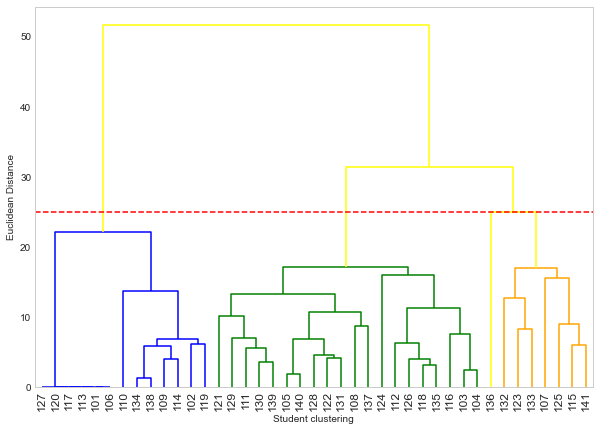

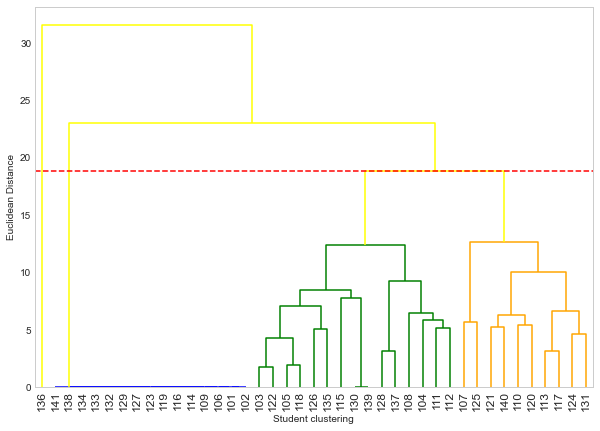

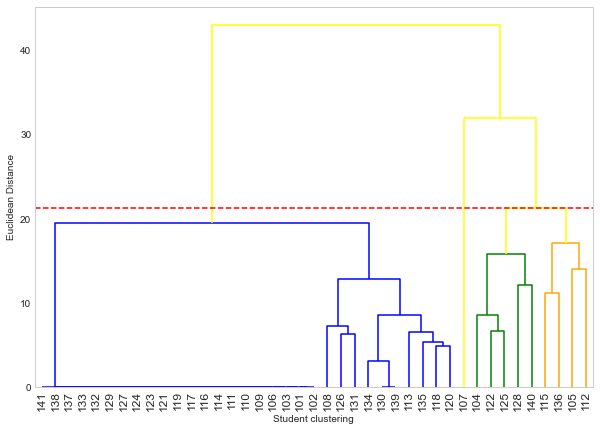

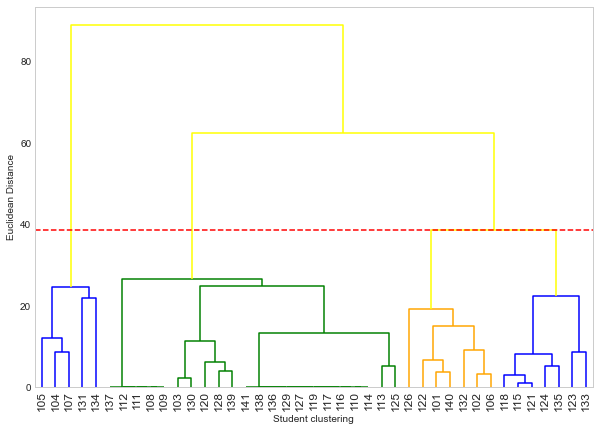

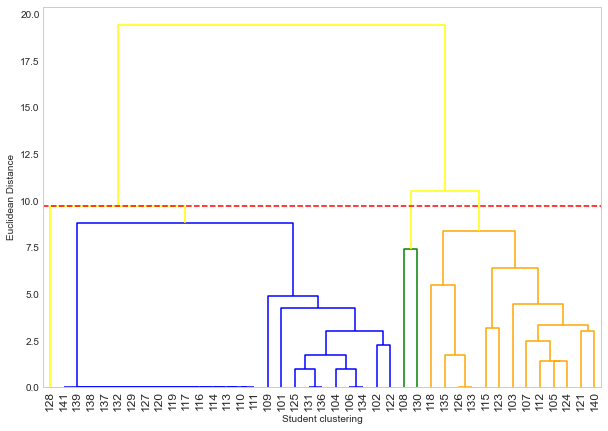

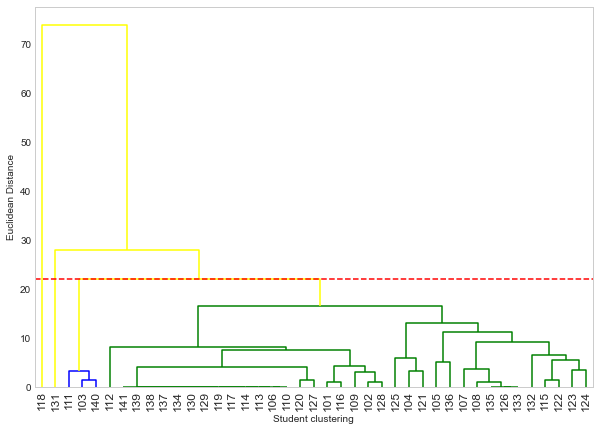

In [48]:
ls_dataset = main(False)